# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band2.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3       4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.970585 -0.459166 -0.9211 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.925795  ...  -1.0 -0.889372 -0.892102  -1.0  -1.0 -0.652577   
      201547 -0.925795  ...  -1.0 -0.889372 -0.892102  -1.0  -1.0 -0.652577   
      201548 -0.925795  ...  -1.0 -0.889372 -0.892102  -1.0  -1.0 -0.652577   
      201549 -0.925795  ...  -1.0 -0.889372 -0.892102  -1.0  -1.0 -0.652577   
      201550 -0.925795  ...  -1.0 -0.889372 -0.892102  -1.0  -1.0 -0.652577   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.927806  -1.0 -0.861740  
      201547  -1.0 -0.927806  -1.0 -0.854589  
      201548  -1.0 -0.927806  -1.0 -0.856973  
      201549  -1.0 -0.927806  -1.0 -0.856973  
      201550  -1.0 -0.927806  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2    3         4    5         6  \
41001 201820 -1.000000 -0.994667 -0.899529 -1.0 -1.000000 -1.0 -0.826560   
      201821 -0.963923 -0.965904 -1.000000 -1.0 -0.923387 -1.0 -0.897881   
      201822 -0.589757 -0.662809 -1.000000 -1.0 -1.000000 -1.0 -0.800236   
      201823 -1.000000 -0.858541 -0.829634 -1.0 -1.000000 -1.0 -1.000000   
      201824 -1.000000 -1.000000 -1.000000 -1.0 -1.000000 -1.0 -0.880512   

                     7         8         9  ...      2039      2040      2041  \
41001 201820 -1.000000 -0.980020 -0.879776  ... -0.856185 -0.162096 -1.000000   
      201821  4.440521 -0.991060 -0.358311  ... -1.000000  0.283647  0.108799   
      201822  4.530493 -0.974174 -0.801964  ... -1.000000 -0.508071 -0.105335   
      201823 -1.000000 -0.949415 -0.950184  ... -1.000000 -0.997376 -1.000000   
      201824 -1.000000 -0.982210 -1.000000  ... -1.000000 -0.293387 -1.000000   

              2042      2043      2044  2045      2046      2047    Labels  
41001 201820  -1.0 -0.896609 -1.000000  -1.0 -0.994096 -1.000000 -0.949940  
      201821  -1.0 -0.945026 -0.805471  -1.0 -0.310819 -1.000000 -0.961859  
      201822  -1.0 -0.980786 -0.863086  -1.0 -0.526583 -0.966365 -0.940405  
      201823  -1.0 -1.000000 -1.000000  -1.0 -0.960629 -1.000000 -0.961859  
      201824  -1.0 -0.956622 -1.000000  -1.0 -0.897912 -1.000000 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

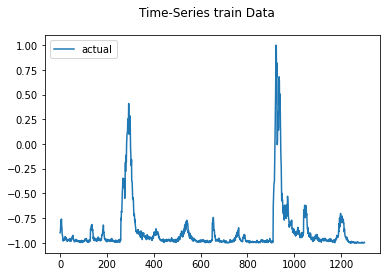

2023-03-07 13:09:16.863688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 13:09:16.863735: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 13:09:16.863759: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 13:09:16.863970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 13:09:17.216218: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 95.891
Test RMSE: 117.797
Test sMAPE: 138.145
Test R Squared: -13.359
{'mae': 95.89099465698906, 'rmse': 117.79729852907862, 'smape': 138.14497522497734, 'r2': -13.358618716401542}


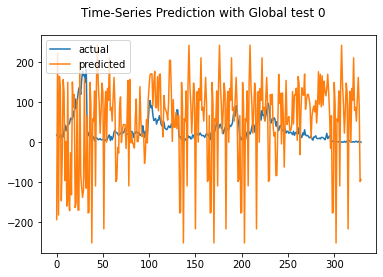

Test MAE: 50.251
Test RMSE: 59.443
Test sMAPE: 110.532
Test R Squared: -2.656
{'mae': 50.250597300312734, 'rmse': 59.44313632027137, 'smape': 110.5315642742266, 'r2': -2.6563303937132265}


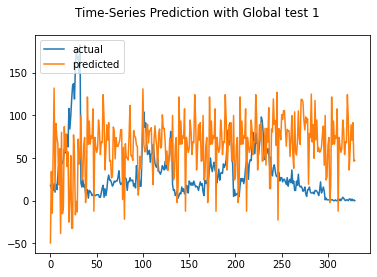

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 31.565
Test RMSE: 42.282
Test sMAPE: 89.953
Test R Squared: -0.850
{'mae': 31.564624832435086, 'rmse': 42.281867957772185, 'smape': 89.95262655063028, 'r2': -0.8499088620991453}


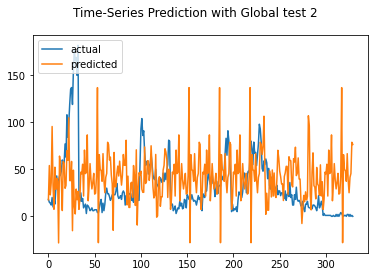

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 37.756
Test RMSE: 47.256
Test sMAPE: 108.062
Test R Squared: -1.311
{'mae': 37.75589151201826, 'rmse': 47.25583089416594, 'smape': 108.06246934468297, 'r2': -1.310749188057529}


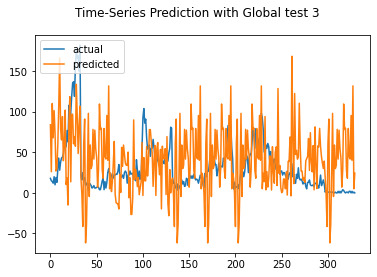

Test MAE: 41.204
Test RMSE: 51.276
Test sMAPE: 107.648
Test R Squared: -1.721
{'mae': 41.203893437530056, 'rmse': 51.27587034380532, 'smape': 107.64816670220016, 'r2': -1.7206212324271157}


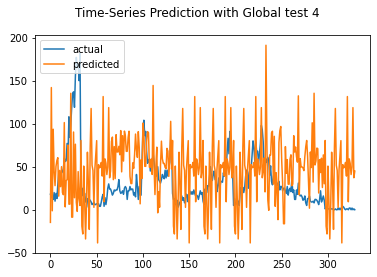

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 52.589
Test RMSE: 71.840
Test sMAPE: 114.425
Test R Squared: -4.340
{'mae': 52.58852401791197, 'rmse': 71.84013817370617, 'smape': 114.42471475370486, 'r2': -4.340431139731761}


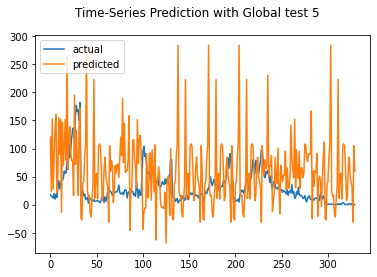

Test MAE: 53.322
Test RMSE: 64.536
Test sMAPE: 114.002
Test R Squared: -3.310
{'mae': 53.321787082787715, 'rmse': 64.53551819271982, 'smape': 114.00234417290058, 'r2': -3.309626220557366}


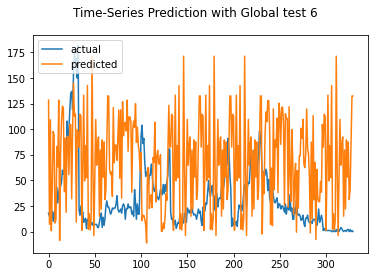

Test MAE: 51.654
Test RMSE: 65.904
Test sMAPE: 139.299
Test R Squared: -3.494
{'mae': 51.654155034368685, 'rmse': 65.9044790744177, 'smape': 139.29871795613434, 'r2': -3.494401480095541}


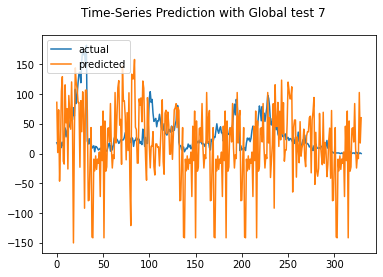

Test MAE: 54.402
Test RMSE: 62.986
Test sMAPE: 110.147
Test R Squared: -3.105
{'mae': 54.40191874215097, 'rmse': 62.986032620409205, 'smape': 110.14675812086992, 'r2': -3.105163976031145}


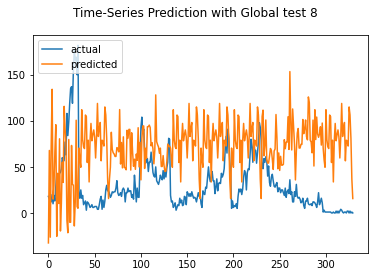

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.344
Test RMSE: 50.200
Test sMAPE: 104.579
Test R Squared: -1.608
{'mae': 39.344291458346625, 'rmse': 50.19957720941129, 'smape': 104.57943946356426, 'r2': -1.6076068940058845}


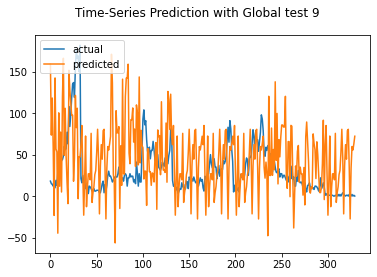

Test MAE: 40.493
Test RMSE: 50.636
Test sMAPE: 100.974
Test R Squared: -1.653
{'mae': 40.49310592367794, 'rmse': 50.63578154759911, 'smape': 100.97443092065906, 'r2': -1.653120875638166}


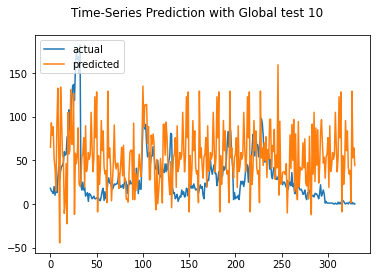

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 45.948
Test RMSE: 59.994
Test sMAPE: 102.730
Test R Squared: -2.724
{'mae': 45.94825872255094, 'rmse': 59.99404479163279, 'smape': 102.73005732430589, 'r2': -2.7244168917342946}


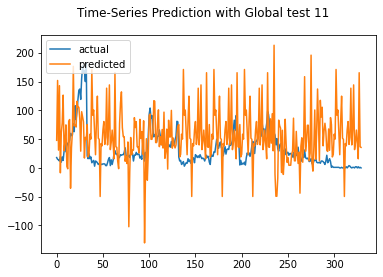

Test MAE: 44.836
Test RMSE: 56.570
Test sMAPE: 114.828
Test R Squared: -2.311
{'mae': 44.83644131349795, 'rmse': 56.57038484236277, 'smape': 114.82765843178166, 'r2': -2.311465753975798}


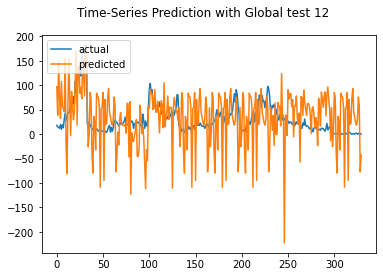

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 52.344
Test RMSE: 64.830
Test sMAPE: 127.561
Test R Squared: -3.349
{'mae': 52.34418741202715, 'rmse': 64.82998528347179, 'smape': 127.56130259242575, 'r2': -3.3490444624642626}


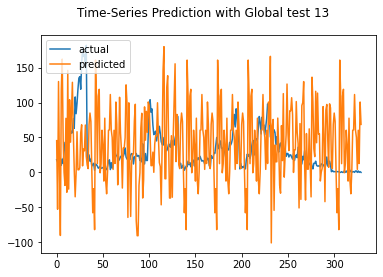

Test MAE: 83.620
Test RMSE: 130.561
Test sMAPE: 110.334
Test R Squared: -16.639
{'mae': 83.6195315693364, 'rmse': 130.56111084278493, 'smape': 110.3344046861994, 'r2': -16.63882594125608}


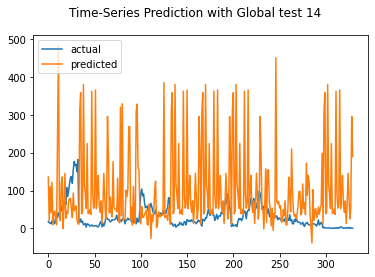

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 60.746
Test RMSE: 77.802
Test sMAPE: 118.194
Test R Squared: -5.264
{'mae': 60.74646489909201, 'rmse': 77.80197248630675, 'smape': 118.19359754632355, 'r2': -5.263588483913231}


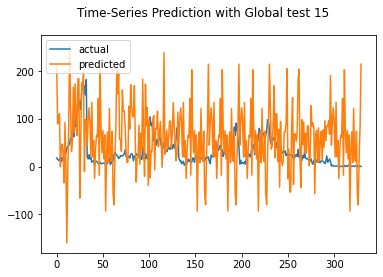

Test MAE: 64.496
Test RMSE: 81.024
Test sMAPE: 142.540
Test R Squared: -5.793
{'mae': 64.49556729865796, 'rmse': 81.0238949722103, 'smape': 142.53965731608884, 'r2': -5.793103554921121}


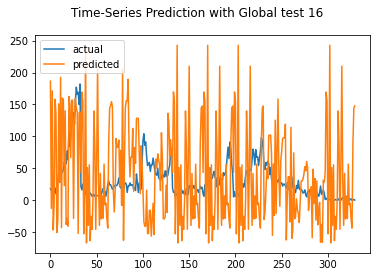

Test MAE: 70.419
Test RMSE: 86.586
Test sMAPE: 154.007
Test R Squared: -6.758
{'mae': 70.41921379204952, 'rmse': 86.58560316852221, 'smape': 154.0073500076434, 'r2': -6.7577070397405}


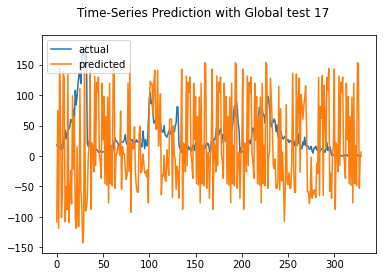

Test MAE: 43.906
Test RMSE: 56.359
Test sMAPE: 104.942
Test R Squared: -2.287
{'mae': 43.90583159056577, 'rmse': 56.359181034758265, 'smape': 104.94230251528911, 'r2': -2.2867853988918707}


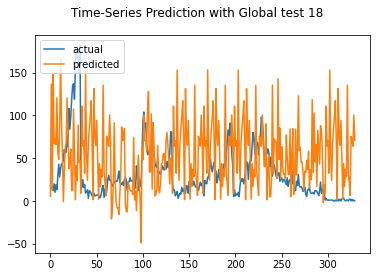

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 39.947
Test RMSE: 53.738
Test sMAPE: 112.694
Test R Squared: -1.988
{'mae': 39.94732525962772, 'rmse': 53.73844800166542, 'smape': 112.69361724090724, 'r2': -1.9882177481203511}


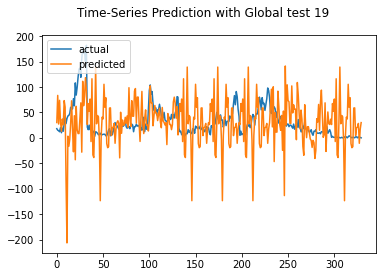

Test MAE: 34.689
Test RMSE: 51.501
Test sMAPE: 129.738
Test R Squared: -1.745
{'mae': 34.6890989224116, 'rmse': 51.50134908813026, 'smape': 129.73807480929844, 'r2': -1.7446009726078042}


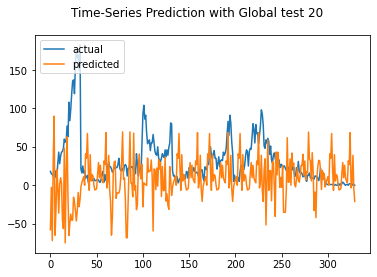

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.691
Test RMSE: 51.414
Test sMAPE: 110.575
Test R Squared: -1.735
{'mae': 39.691050453800145, 'rmse': 51.41441524591734, 'smape': 110.57517213029513, 'r2': -1.7353430663273115}


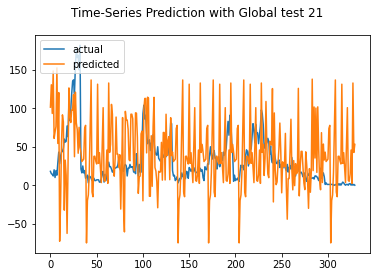

Test MAE: 65.505
Test RMSE: 76.523
Test sMAPE: 111.703
Test R Squared: -5.059
{'mae': 65.50495151172984, 'rmse': 76.52323910992554, 'smape': 111.70289239442359, 'r2': -5.059387004736192}


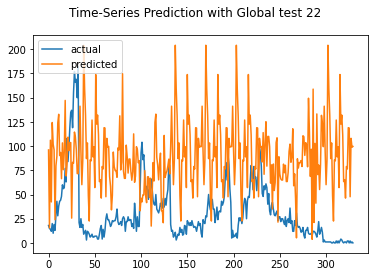

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 34.403
Test RMSE: 45.398
Test sMAPE: 114.446
Test R Squared: -1.133
{'mae': 34.40297803093087, 'rmse': 45.3975335857074, 'smape': 114.44569286863786, 'r2': -1.1325858283415906}


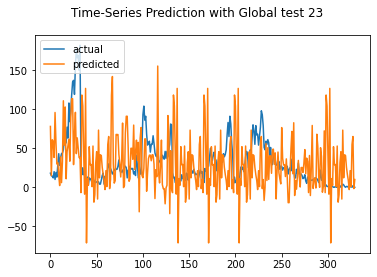

Test MAE: 47.702
Test RMSE: 64.660
Test sMAPE: 110.970
Test R Squared: -3.326
{'mae': 47.70207153558731, 'rmse': 64.65979043349185, 'smape': 110.96956657463845, 'r2': -3.3262397870749307}


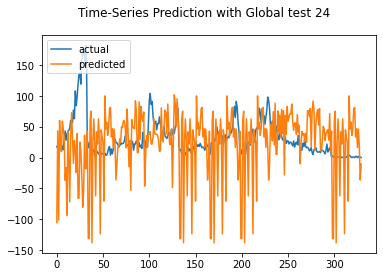

Test MAE: 48.604
Test RMSE: 72.142
Test sMAPE: 113.161
Test R Squared: -4.385
{'mae': 48.604148726662, 'rmse': 72.1423757879977, 'smape': 113.1611787786438, 'r2': -4.385460965473441}


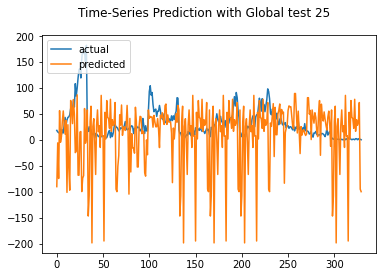

Test MAE: 67.703
Test RMSE: 78.915
Test sMAPE: 117.645
Test R Squared: -5.444
{'mae': 67.70259587836988, 'rmse': 78.91485113251026, 'smape': 117.64471963821084, 'r2': -5.444058655658271}


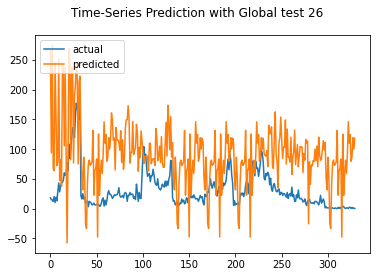

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 41.107
Test RMSE: 50.823
Test sMAPE: 108.825
Test R Squared: -1.673
{'mae': 41.10716184413794, 'rmse': 50.82303764239348, 'smape': 108.82523076865935, 'r2': -1.6727801628346337}


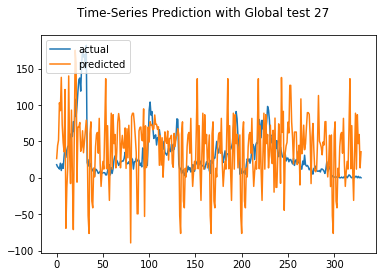

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 43.361
Test RMSE: 57.335
Test sMAPE: 117.486
Test R Squared: -2.402
{'mae': 43.36137196313251, 'rmse': 57.335301294301175, 'smape': 117.48591740728126, 'r2': -2.401623160034917}


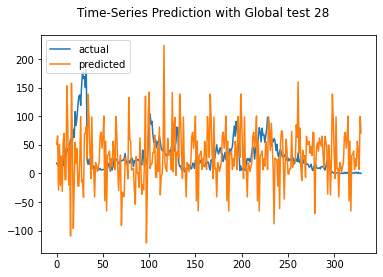

Test MAE: 71.421
Test RMSE: 94.432
Test sMAPE: 130.411
Test R Squared: -8.228
{'mae': 71.42126531709324, 'rmse': 94.43240396065076, 'smape': 130.41125227507777, 'r2': -8.227500830183846}


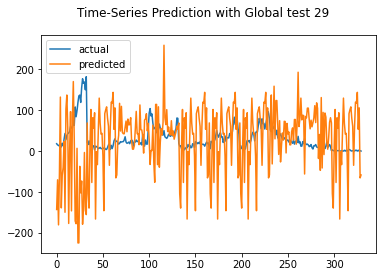

Test MAE: 43.496
Test RMSE: 58.714
Test sMAPE: 112.874
Test R Squared: -2.567
{'mae': 43.49628241893017, 'rmse': 58.71399979571944, 'smape': 112.87369294395204, 'r2': -2.567182556463105}


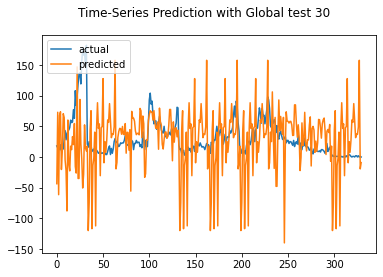

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 43.572
Test RMSE: 52.628
Test sMAPE: 100.390
Test R Squared: -1.866
{'mae': 43.57165797786279, 'rmse': 52.62823827482967, 'smape': 100.38961308578928, 'r2': -1.866022966609667}


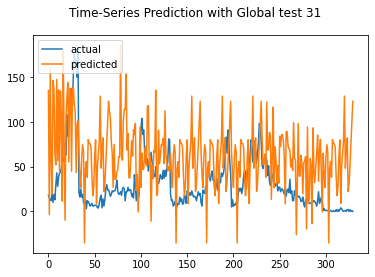

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 48.835
Test RMSE: 60.856
Test sMAPE: 111.434
Test R Squared: -2.832
{'mae': 48.8350789084579, 'rmse': 60.855621475463174, 'smape': 111.4336373385758, 'r2': -2.8321579890873037}


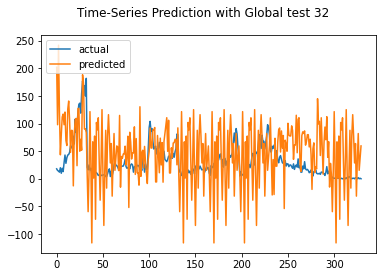

Test MAE: 42.730
Test RMSE: 53.907
Test sMAPE: 106.238
Test R Squared: -2.007
{'mae': 42.730278069684, 'rmse': 53.90724800768821, 'smape': 106.2379838876621, 'r2': -2.0070200546925023}


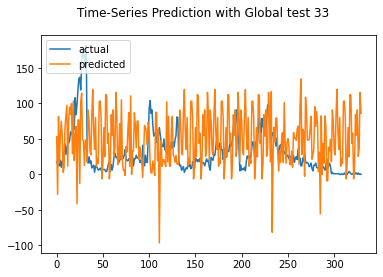

Test MAE: 37.162
Test RMSE: 46.016
Test sMAPE: 98.069
Test R Squared: -1.191
{'mae': 37.162268135764386, 'rmse': 46.016455979404896, 'smape': 98.06946846657603, 'r2': -1.191130970026478}


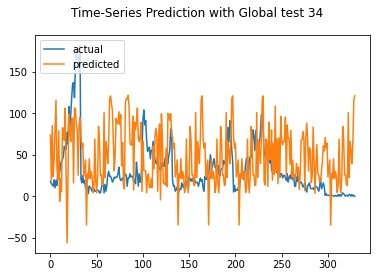

Test MAE: 77.211
Test RMSE: 100.340
Test sMAPE: 126.686
Test R Squared: -9.418
{'mae': 77.21101931730907, 'rmse': 100.34003090648571, 'smape': 126.68599799940465, 'r2': -9.418146557536133}


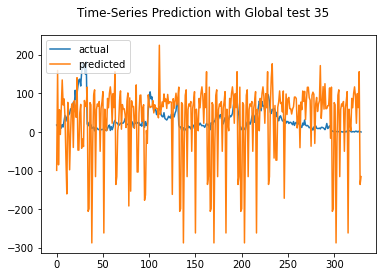

Test MAE: 78.061
Test RMSE: 86.926
Test sMAPE: 130.638
Test R Squared: -6.819
{'mae': 78.06123489322084, 'rmse': 86.92573195016725, 'smape': 130.63844232791197, 'r2': -6.818774975020255}


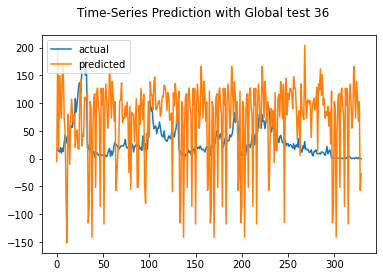

Test MAE: 49.369
Test RMSE: 57.560
Test sMAPE: 109.595
Test R Squared: -2.428
{'mae': 49.36886002439441, 'rmse': 57.560276155184006, 'smape': 109.59457999796952, 'r2': -2.428370420432006}


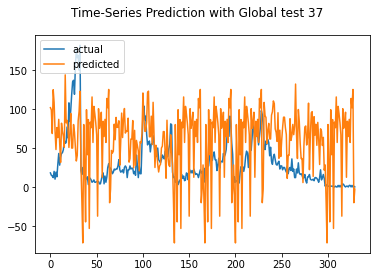

Test MAE: 61.469
Test RMSE: 75.260
Test sMAPE: 117.752
Test R Squared: -4.861
{'mae': 61.46932457432602, 'rmse': 75.2600759608337, 'smape': 117.75207467806648, 'r2': -4.8609943984055155}


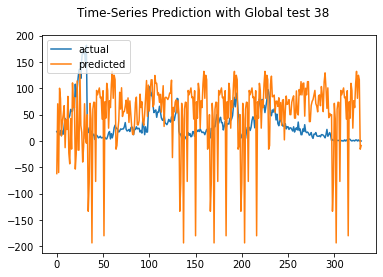

Test MAE: 33.332
Test RMSE: 42.187
Test sMAPE: 91.481
Test R Squared: -0.842
{'mae': 33.33248417016232, 'rmse': 42.187226154319056, 'smape': 91.48053335782, 'r2': -0.8416366274377178}


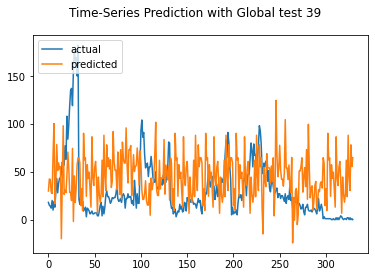

Test MAE: 31.444
Test RMSE: 38.168
Test sMAPE: 93.109
Test R Squared: -0.507
{'mae': 31.443851975058063, 'rmse': 38.167955660069936, 'smape': 93.10907638633833, 'r2': -0.5074391829452556}


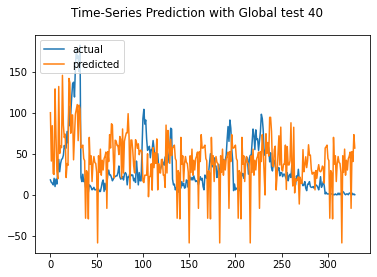

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 45.636
Test RMSE: 59.198
Test sMAPE: 120.303
Test R Squared: -2.626
{'mae': 45.63567240572337, 'rmse': 59.197640749129405, 'smape': 120.30287218386974, 'r2': -2.6261920316530634}


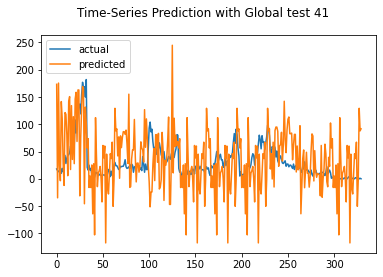

Test MAE: 93.401
Test RMSE: 106.855
Test sMAPE: 138.668
Test R Squared: -10.815
{'mae': 93.40062730041417, 'rmse': 106.8546986884984, 'smape': 138.66757451105303, 'r2': -10.814878223468016}


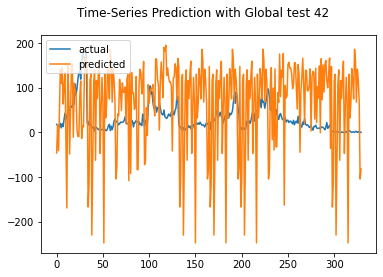

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 55.497
Test RMSE: 70.607
Test sMAPE: 115.793
Test R Squared: -4.159
{'mae': 55.496741117130625, 'rmse': 70.60716931493953, 'smape': 115.79322421052495, 'r2': -4.158692047662613}


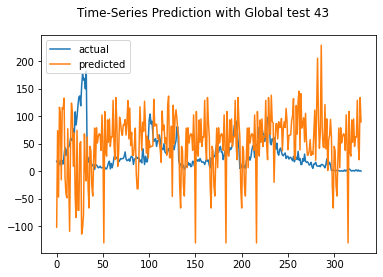

Test MAE: 107.968
Test RMSE: 139.678
Test sMAPE: 140.997
Test R Squared: -19.188
{'mae': 107.96827028303436, 'rmse': 139.6776903479377, 'smape': 140.99721231688267, 'r2': -19.188129962913976}


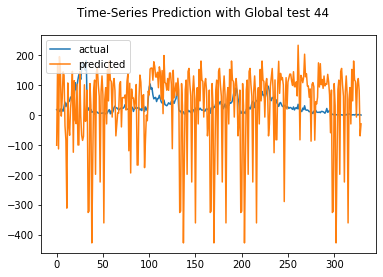

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.122
Test RMSE: 56.524
Test sMAPE: 116.109
Test R Squared: -2.306
{'mae': 44.121556521726376, 'rmse': 56.524379233751645, 'smape': 116.1094179880122, 'r2': -2.3060818750969263}


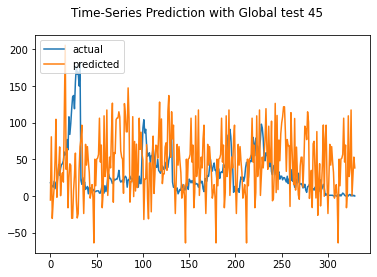

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 42.153
Test RMSE: 52.509
Test sMAPE: 106.062
Test R Squared: -1.853
{'mae': 42.15307453292789, 'rmse': 52.50850008925327, 'smape': 106.06195184466189, 'r2': -1.852996423699385}


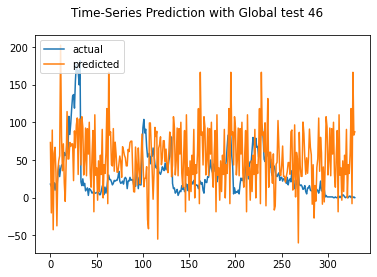

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 34.510
Test RMSE: 45.059
Test sMAPE: 96.915
Test R Squared: -1.101
{'mae': 34.509789153301355, 'rmse': 45.059059307351184, 'smape': 96.91524384753225, 'r2': -1.10090417056966}


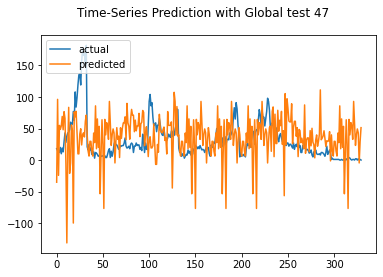

Test MAE: 87.974
Test RMSE: 141.677
Test sMAPE: 130.627
Test R Squared: -19.770
{'mae': 87.97439211408297, 'rmse': 141.676552602012, 'smape': 130.62693906736982, 'r2': -19.77007013419261}


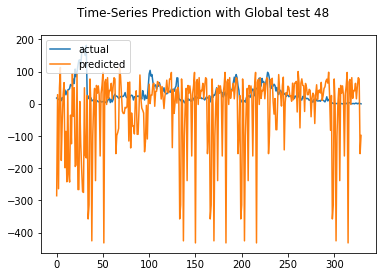

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 37.274
Test RMSE: 51.740
Test sMAPE: 114.092
Test R Squared: -1.770
{'mae': 37.27428230878078, 'rmse': 51.74046410229294, 'smape': 114.09166656098402, 'r2': -1.7701458881705698}


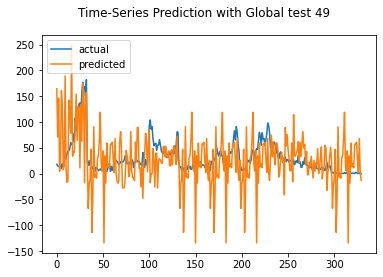

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 60.849
Test RMSE: 75.811
Test sMAPE: 119.187
Test R Squared: -4.947
{'mae': 60.84886294025363, 'rmse': 75.81110540527158, 'smape': 119.1869028881405, 'r2': -4.9471331222161075}


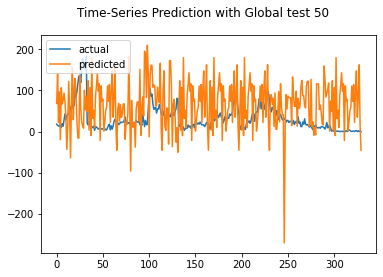

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 30.120
Test RMSE: 40.441
Test sMAPE: 106.472
Test R Squared: -0.692
{'mae': 30.120421501632894, 'rmse': 40.44096465763868, 'smape': 106.47244391751936, 'r2': -0.6923298493824717}


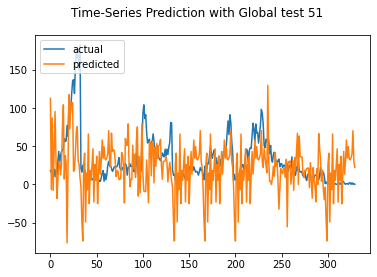

Test MAE: 43.678
Test RMSE: 64.037
Test sMAPE: 105.543
Test R Squared: -3.243
{'mae': 43.678003226988245, 'rmse': 64.0374206012127, 'smape': 105.54266223074283, 'r2': -3.243357892410292}


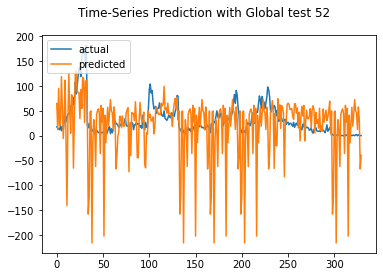

Test MAE: 65.001
Test RMSE: 93.217
Test sMAPE: 114.695
Test R Squared: -7.992
{'mae': 65.0014163143707, 'rmse': 93.21749498140936, 'smape': 114.69472521295134, 'r2': -7.991597496377665}


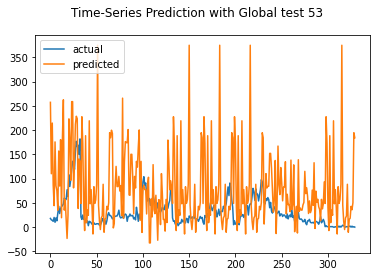

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 54.192
Test RMSE: 67.662
Test sMAPE: 122.895
Test R Squared: -3.737
{'mae': 54.191970869627866, 'rmse': 67.6619302763462, 'smape': 122.89534639787841, 'r2': -3.7372986908782773}


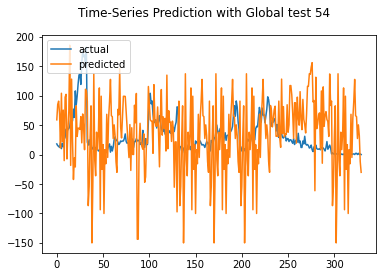

Test MAE: 63.612
Test RMSE: 78.041
Test sMAPE: 113.981
Test R Squared: -5.302
{'mae': 63.61187408909653, 'rmse': 78.04111959580548, 'smape': 113.98100021854424, 'r2': -5.30215360454442}


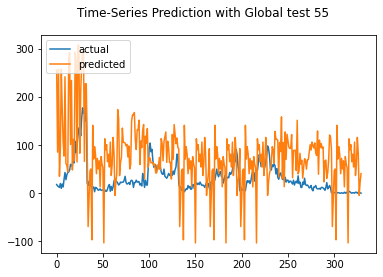

Test MAE: 93.283
Test RMSE: 135.193
Test sMAPE: 129.294
Test R Squared: -17.913
{'mae': 93.28337568008538, 'rmse': 135.19312926103498, 'smape': 129.2939114185202, 'r2': -17.912600239726117}


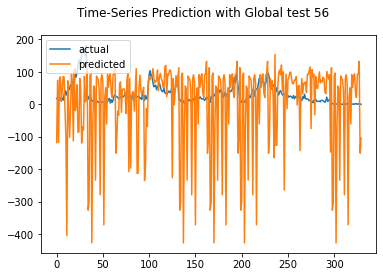

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 47.787
Test RMSE: 62.736
Test sMAPE: 115.379
Test R Squared: -3.073
{'mae': 47.787424404873995, 'rmse': 62.73626537122332, 'smape': 115.37896553657122, 'r2': -3.072670976595182}


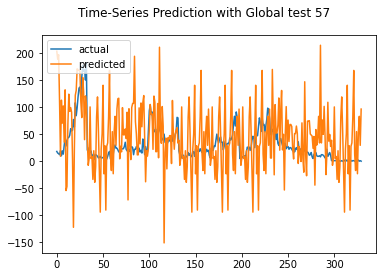

Test MAE: 57.157
Test RMSE: 67.565
Test sMAPE: 118.319
Test R Squared: -3.724
{'mae': 57.15656046939618, 'rmse': 67.56473872638318, 'smape': 118.31917514988851, 'r2': -3.7236988802800512}


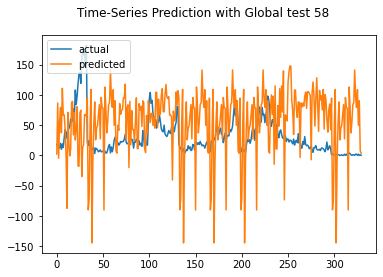

Test MAE: 86.969
Test RMSE: 110.543
Test sMAPE: 138.861
Test R Squared: -11.644
{'mae': 86.96860117677487, 'rmse': 110.54259815971699, 'smape': 138.86106636441798, 'r2': -11.64449058663413}


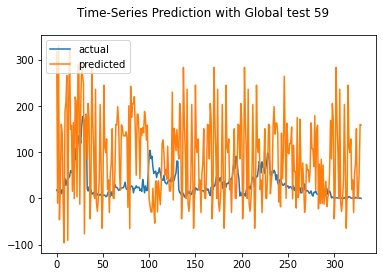

Test MAE: 52.023
Test RMSE: 65.832
Test sMAPE: 119.091
Test R Squared: -3.485
{'mae': 52.023355932037035, 'rmse': 65.83224502557685, 'smape': 119.09057474328593, 'r2': -3.484554777525968}


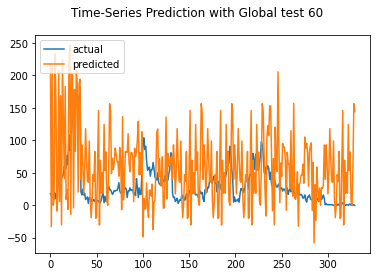

Test MAE: 33.620
Test RMSE: 42.147
Test sMAPE: 92.898
Test R Squared: -0.838
{'mae': 33.619528862924284, 'rmse': 42.14742903635681, 'smape': 92.89836694792812, 'r2': -0.8381636681068949}


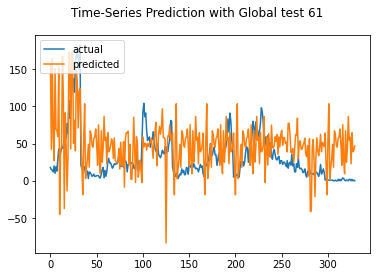

Test MAE: 51.963
Test RMSE: 65.695
Test sMAPE: 114.594
Test R Squared: -3.466
{'mae': 51.96268703359546, 'rmse': 65.69460720976569, 'smape': 114.59437304808958, 'r2': -3.4658223439929854}


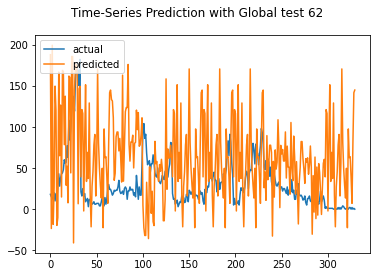

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 54.610
Test RMSE: 67.464
Test sMAPE: 114.276
Test R Squared: -3.710
{'mae': 54.60997947689259, 'rmse': 67.46389311443326, 'smape': 114.27640336022347, 'r2': -3.70960842990935}


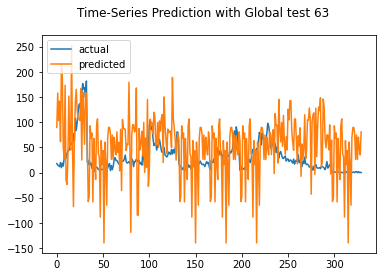

Test MAE: 60.103
Test RMSE: 71.991
Test sMAPE: 107.767
Test R Squared: -4.363
{'mae': 60.10322932980277, 'rmse': 71.99064326968887, 'smape': 107.76670175609624, 'r2': -4.362830986462746}


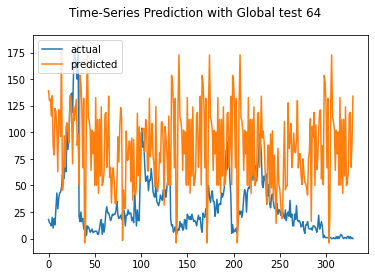

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 59.994
Test RMSE: 79.464
Test sMAPE: 128.761
Test R Squared: -5.534
{'mae': 59.99363731868339, 'rmse': 79.46351417405795, 'smape': 128.7612328998826, 'r2': -5.5339760191930685}


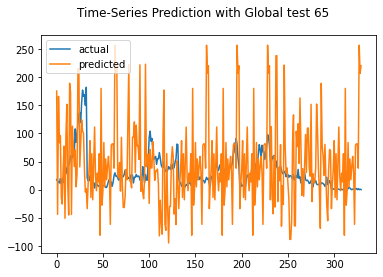

Test MAE: 44.328
Test RMSE: 55.280
Test sMAPE: 103.897
Test R Squared: -2.162
{'mae': 44.32771625302055, 'rmse': 55.27973368584829, 'smape': 103.89688518383875, 'r2': -2.1620875184410666}


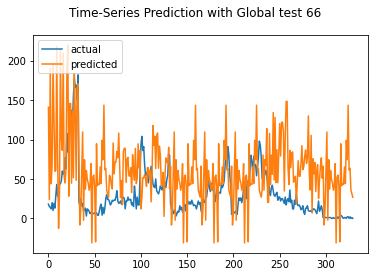

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 42.178
Test RMSE: 52.991
Test sMAPE: 113.511
Test R Squared: -1.906
{'mae': 42.17826420267423, 'rmse': 52.990888460741616, 'smape': 113.51050138910712, 'r2': -1.9056573839885305}


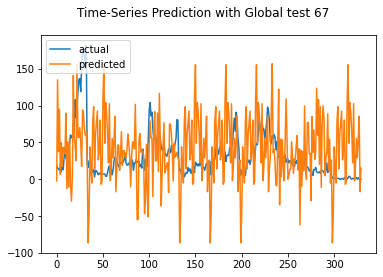

Test MAE: 41.051
Test RMSE: 52.988
Test sMAPE: 95.704
Test R Squared: -1.905
{'mae': 41.05066220110113, 'rmse': 52.98803368477957, 'smape': 95.7038395592845, 'r2': -1.9053443196993074}


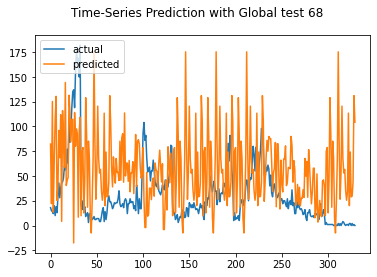

Test MAE: 59.365
Test RMSE: 78.741
Test sMAPE: 108.385
Test R Squared: -5.416
{'mae': 59.36518325516672, 'rmse': 78.74138165523088, 'smape': 108.38473922208753, 'r2': -5.415759321566099}


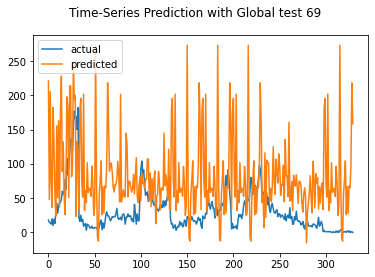

Test MAE: 87.201
Test RMSE: 112.375
Test sMAPE: 115.906
Test R Squared: -12.067
{'mae': 87.20100368080718, 'rmse': 112.37505003786708, 'smape': 115.90636782670833, 'r2': -12.067177724528008}


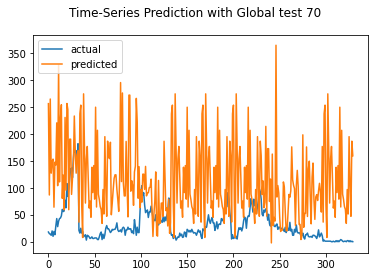

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 37.393
Test RMSE: 50.729
Test sMAPE: 125.874
Test R Squared: -1.663
{'mae': 37.39261728010394, 'rmse': 50.72922962605202, 'smape': 125.87418258531261, 'r2': -1.6629225540579813}


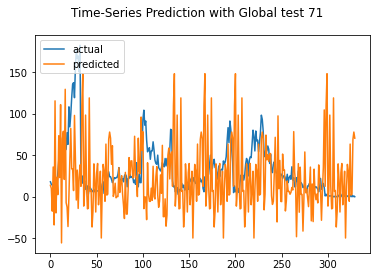

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 55.678
Test RMSE: 71.944
Test sMAPE: 113.894
Test R Squared: -4.356
{'mae': 55.67844427246036, 'rmse': 71.94367425095396, 'smape': 113.89383405608656, 'r2': -4.355835501270087}


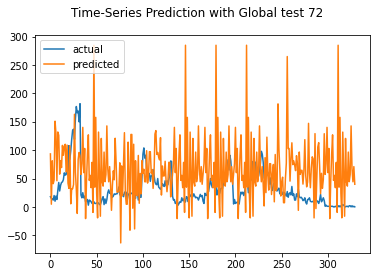

Test MAE: 68.887
Test RMSE: 93.378
Test sMAPE: 128.625
Test R Squared: -8.023
{'mae': 68.88713173197978, 'rmse': 93.37796555612503, 'smape': 128.6251501137859, 'r2': -8.02258156770677}


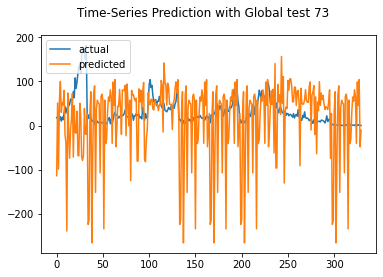

Test MAE: 60.038
Test RMSE: 73.718
Test sMAPE: 129.075
Test R Squared: -4.623
{'mae': 60.03821743022312, 'rmse': 73.71775199054383, 'smape': 129.0752308708848, 'r2': -4.62323414876508}


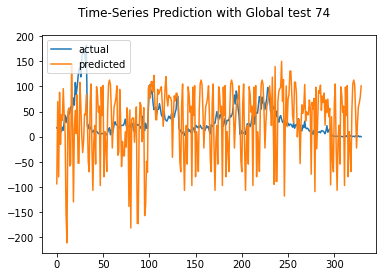

Test MAE: 134.420
Test RMSE: 197.707
Test sMAPE: 135.883
Test R Squared: -39.447
{'mae': 134.41964264132758, 'rmse': 197.70745388306935, 'smape': 135.882641326382, 'r2': -39.44716512980061}


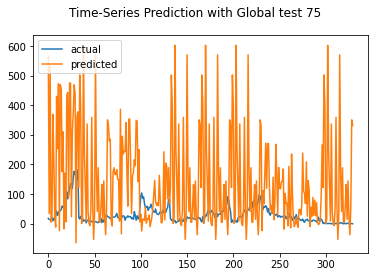

Test MAE: 42.309
Test RMSE: 56.694
Test sMAPE: 107.539
Test R Squared: -2.326
{'mae': 42.309481313914965, 'rmse': 56.69367986979774, 'smape': 107.53946904238835, 'r2': -2.3259161485669657}


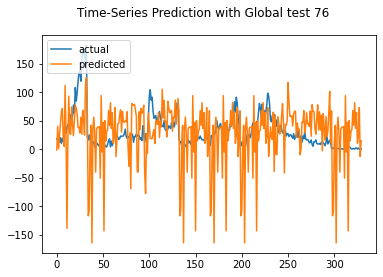

Test MAE: 115.011
Test RMSE: 158.316
Test sMAPE: 125.379
Test R Squared: -24.935
{'mae': 115.01090455488725, 'rmse': 158.31581356082057, 'smape': 125.37886904973122, 'r2': -24.93525937969617}


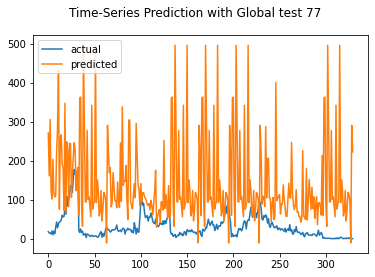

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 42.572
Test RMSE: 49.931
Test sMAPE: 99.282
Test R Squared: -1.580
{'mae': 42.571630813858725, 'rmse': 49.931254731082205, 'smape': 99.28219560005859, 'r2': -1.5798054801483326}


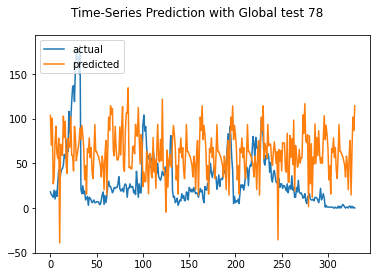

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 58.185
Test RMSE: 68.087
Test sMAPE: 111.142
Test R Squared: -3.797
{'mae': 58.18473729292552, 'rmse': 68.08657682664372, 'smape': 111.1424741059262, 'r2': -3.796947896474734}


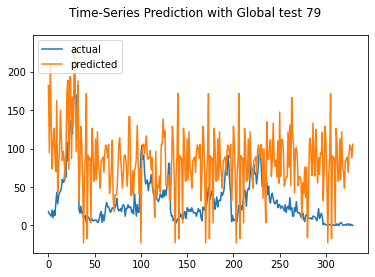

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 54.035
Test RMSE: 67.586
Test sMAPE: 117.173
Test R Squared: -3.727
{'mae': 54.03503689820116, 'rmse': 67.58601973383435, 'smape': 117.1728337109506, 'r2': -3.7266750155914528}


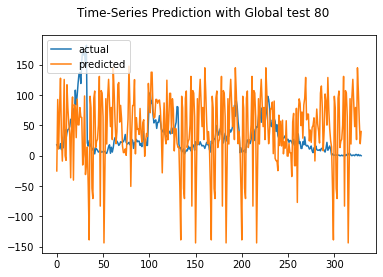

Test MAE: 47.783
Test RMSE: 57.407
Test sMAPE: 122.678
Test R Squared: -2.410
{'mae': 47.78316788203789, 'rmse': 57.40676723761204, 'smape': 122.6775372796352, 'r2': -2.4101083937151353}


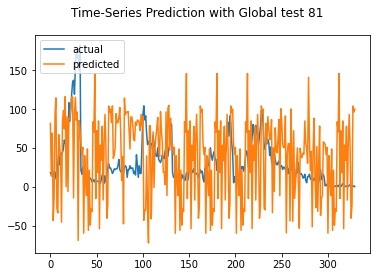

Test MAE: 114.219
Test RMSE: 161.457
Test sMAPE: 140.219
Test R Squared: -25.975
{'mae': 114.21895194848379, 'rmse': 161.45735178899645, 'smape': 140.21917366882664, 'r2': -25.97476386222605}


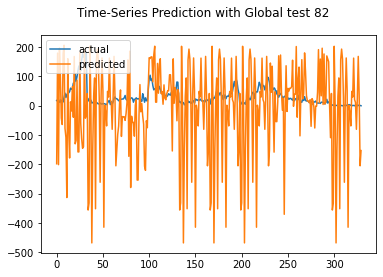

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 49.779
Test RMSE: 63.292
Test sMAPE: 121.695
Test R Squared: -3.145
{'mae': 49.779095348806095, 'rmse': 63.29180892616244, 'smape': 121.6945359830883, 'r2': -3.1451191458638004}


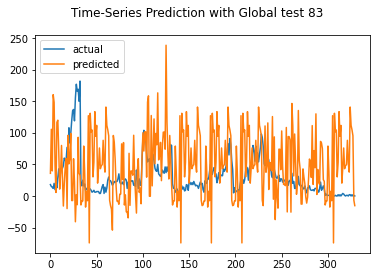

Test MAE: 55.151
Test RMSE: 65.826
Test sMAPE: 105.580
Test R Squared: -3.484
{'mae': 55.15062870690317, 'rmse': 65.82646988700374, 'smape': 105.57965080661762, 'r2': -3.4837679962373675}


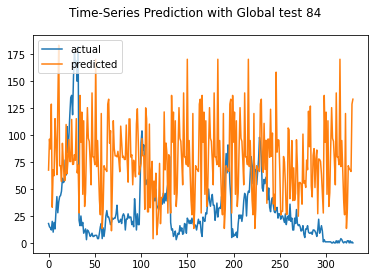

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 43.059
Test RMSE: 54.565
Test sMAPE: 112.853
Test R Squared: -2.081
{'mae': 43.058559913797815, 'rmse': 54.56545320663287, 'smape': 112.85331127386546, 'r2': -2.0808995236663645}


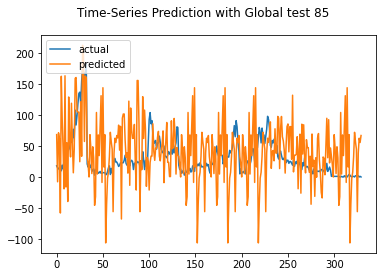

Test MAE: 39.080
Test RMSE: 50.498
Test sMAPE: 93.027
Test R Squared: -1.639
{'mae': 39.08029574553172, 'rmse': 50.49751563907947, 'smape': 93.0268701363347, 'r2': -1.6386514504122602}


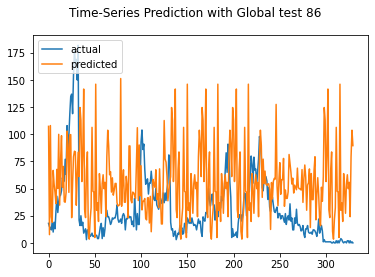

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 37.890
Test RMSE: 50.275
Test sMAPE: 104.352
Test R Squared: -1.615
{'mae': 37.89027149045106, 'rmse': 50.274859418769175, 'smape': 104.35209680950368, 'r2': -1.6154337967528485}


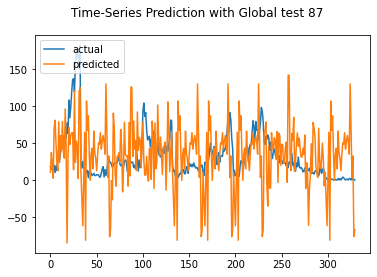

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 48.398
Test RMSE: 64.319
Test sMAPE: 113.862
Test R Squared: -3.281
{'mae': 48.398111978444184, 'rmse': 64.31909825907982, 'smape': 113.86156760769495, 'r2': -3.280770013622141}


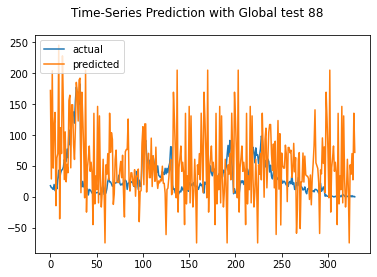

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 36.291
Test RMSE: 45.527
Test sMAPE: 104.155
Test R Squared: -1.145
{'mae': 36.291210633155075, 'rmse': 45.52651870234361, 'smape': 104.1554802034727, 'r2': -1.1447214040909146}


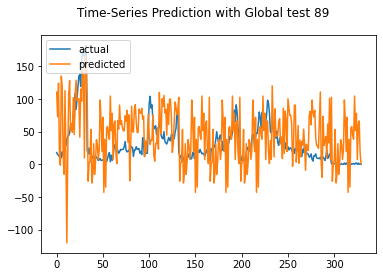

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 38.914
Test RMSE: 50.110
Test sMAPE: 105.349
Test R Squared: -1.598
{'mae': 38.913620774493076, 'rmse': 50.10982926606318, 'smape': 105.34880999196629, 'r2': -1.598291351163236}


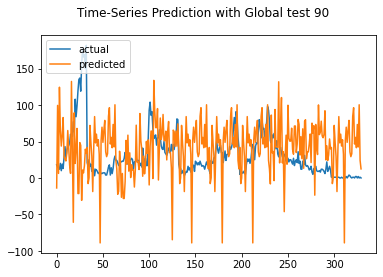

Test MAE: 51.794
Test RMSE: 64.474
Test sMAPE: 111.927
Test R Squared: -3.301
{'mae': 51.794427272045255, 'rmse': 64.47423345258917, 'smape': 111.92696545535827, 'r2': -3.3014450228172247}


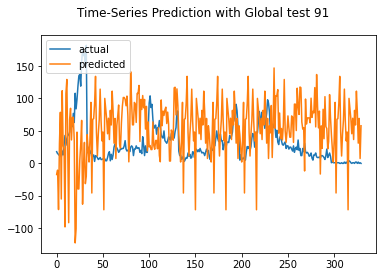

Test MAE: 75.822
Test RMSE: 88.808
Test sMAPE: 120.300
Test R Squared: -7.161
{'mae': 75.82185774716464, 'rmse': 88.80805146765364, 'smape': 120.30023305923545, 'r2': -7.161062133599973}


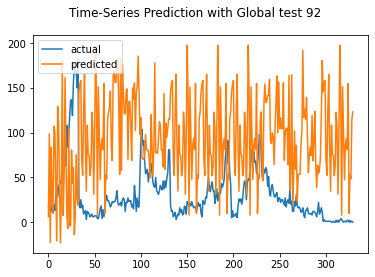

Test MAE: 75.594
Test RMSE: 110.842
Test sMAPE: 111.746
Test R Squared: -11.713
{'mae': 75.59395297801856, 'rmse': 110.8416905355255, 'smape': 111.7457740579986, 'r2': -11.713006924237428}


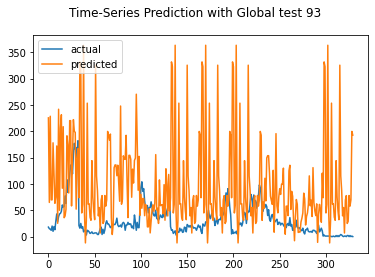

Test MAE: 80.276
Test RMSE: 123.654
Test sMAPE: 125.224
Test R Squared: -14.822
{'mae': 80.27569353002491, 'rmse': 123.65410575160385, 'smape': 125.22432911792518, 'r2': -14.821916337886453}


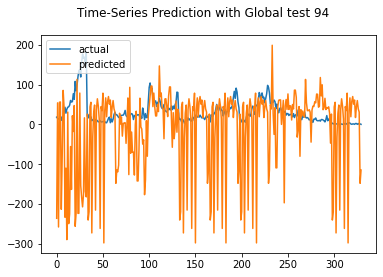

Test MAE: 53.088
Test RMSE: 75.856
Test sMAPE: 117.062
Test R Squared: -4.954
{'mae': 53.08759083558213, 'rmse': 75.85632341854289, 'smape': 117.06157060022576, 'r2': -4.954229648293486}


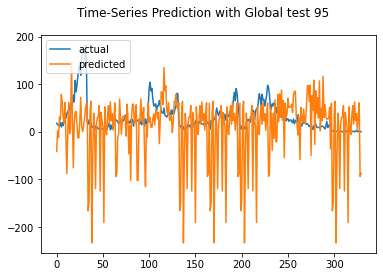

Test MAE: 47.978
Test RMSE: 60.524
Test sMAPE: 98.820
Test R Squared: -2.790
{'mae': 47.97750394994562, 'rmse': 60.52350917996597, 'smape': 98.81983709045316, 'r2': -2.7904450319947682}


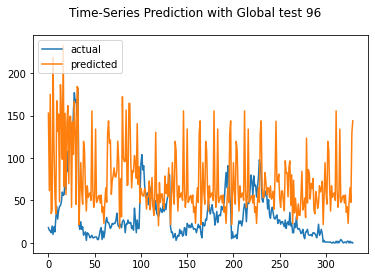

Test MAE: 73.918
Test RMSE: 114.079
Test sMAPE: 113.937
Test R Squared: -12.466
{'mae': 73.91835565603141, 'rmse': 114.0785866660483, 'smape': 113.93652020855583, 'r2': -12.466361404152124}


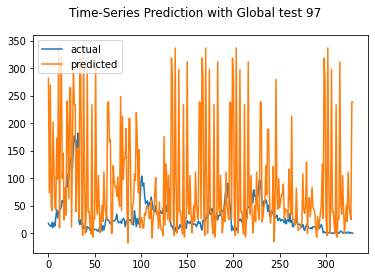

Test MAE: 101.962
Test RMSE: 148.543
Test sMAPE: 122.725
Test R Squared: -21.832
{'mae': 101.962198161537, 'rmse': 148.5430333655897, 'smape': 122.72486542058351, 'r2': -21.83213787230747}


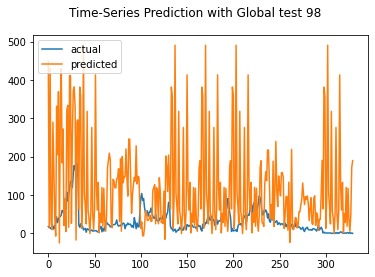

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 45.956
Test RMSE: 60.739
Test sMAPE: 119.554
Test R Squared: -2.818
{'mae': 45.95585689942042, 'rmse': 60.73915626583766, 'smape': 119.55380644912034, 'r2': -2.8175040919866228}


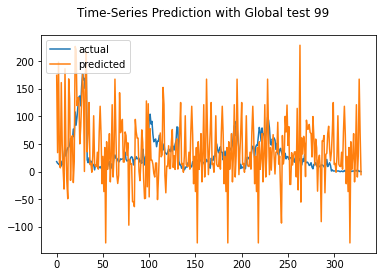

rmse : average=73.303, std=29.881
mae : average=56.187, std=20.406
smape : average=115.267, std=12.358
r2 : average=-5.484, std=6.297


([73.3027143717784, 29.881104715644785],
 [56.186990001436435, 20.406195684852918],
 [115.26733056745314, 12.358490821084143],
 [-5.484015742026943, 6.29687301294])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')